In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import math
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import seaborn as sns
import pandas as pd
import yaml



In [24]:
'''
REDUCE OVERFITTING

dropout 0.25 -> 0.4
L2 reg to optimizer
reduce layers

'''

'\nREDUCE OVERFITTING\n\ndropout 0.25 -> 0.4\nL2 reg to optimizer\nreduce layers\n\n'

In [25]:
torch.manual_seed(42)

BATCH_SIZE = 64

transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5,)*3, (0.5,)*3)
])

data_root  = "../../mega_batch"               # <-- your folder
full_ds    = datasets.ImageFolder(data_root, transform=transform)

# Calculate lengths for train, validation, and test splits
train_len = int(0.8 * len(full_ds))
test_len = len(full_ds) - train_len  # Remaining samples for the test set

# Split the dataset
train_set, test_set = random_split(full_ds, [train_len, test_len])

# Create DataLoaders for each set
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print("Class mapping:", full_ds.class_to_idx              # Option A
      if isinstance(train_set, torch.utils.data.Subset)   
      else train_set.class_to_idx)     

Class mapping: {'lebron': 0, 'other': 1}


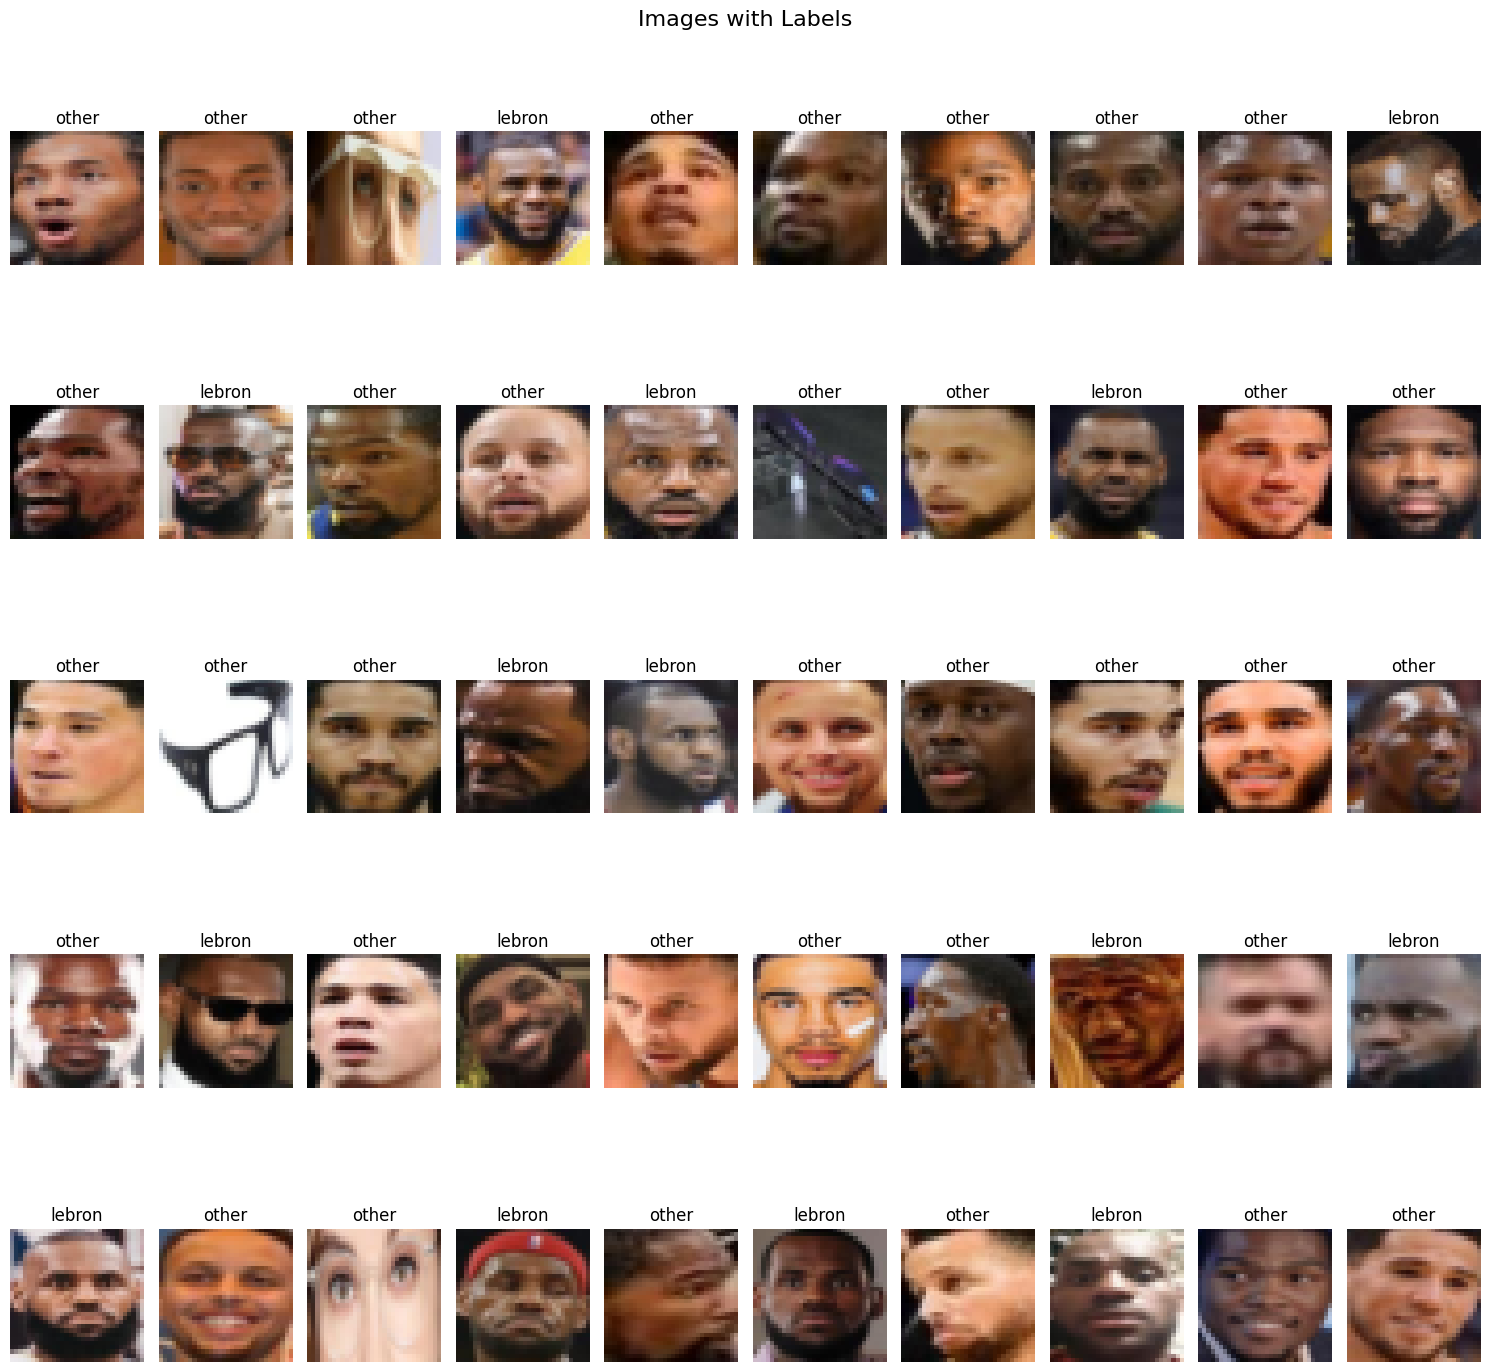

In [26]:
import matplotlib.pyplot as plt

def display_training_images(dataset, idx_to_class, num_images=10, images_per_row=10):
    """
    Displays images from the training set with their corresponding labels.

    Parameters:
    - dataset: The dataset (e.g., train_set).
    - idx_to_class: A dictionary mapping class indices to class names.
    - num_images: Number of images to display.
    """
    num_rows = math.ceil(num_images / images_per_row)  # Calculate the number of rows
    fig, axes = plt.subplots(num_rows, images_per_row, figsize=(15, 3 * num_rows))
    fig.suptitle("Images with Labels", fontsize=16)

    for i in range(num_images):
        row = i // images_per_row
        col = i % images_per_row
        img, label = dataset[i]  # Get image and label
        img = img.permute(1, 2, 0).numpy() * 0.5 + 0.5  # Unnormalize the image

        axes[row, col].imshow(img)
        axes[row, col].axis('off')
        axes[row, col].set_title(idx_to_class[label])

    # Hide unused axes
    for i in range(num_images, num_rows * images_per_row):
        row = i // images_per_row
        col = i % images_per_row
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

# Define idx_to_class
idx_to_class = {v: k for k, v in full_ds.class_to_idx.items()}

# Call the function to display images
display_training_images(test_set, idx_to_class, num_images=50)

In [27]:
from collections import Counter

# Function to calculate class distribution
def get_class_distribution(dataset):
    targets = [label for _, label in dataset]
    return Counter(targets)

# Print class distribution for each dataset
print("Class distribution in Training set:", get_class_distribution(train_set))
print("Class distribution in Test set:", get_class_distribution(test_set))

Class distribution in Training set: Counter({1: 938, 0: 292})
Class distribution in Test set: Counter({1: 228, 0: 80})


In [28]:
class SimpleBinaryCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),          # 128×4×4 = 2048 (assuming input size 32×32)
            nn.Linear(2048, 256), nn.ReLU(),  # Reduced fully connected layer
            nn.Dropout(0.4),
            nn.Linear(256, 1)      # Single output logit
        )

    def forward(self, x):
        return self.classifier(self.features(x))

In [29]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
model = SimpleBinaryCNN().to(device)

learning_rate = 1e-3
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4) # L2 regularization


cuda


# Training

In [30]:
def train_model(batch_size, dropout_rate, learning_rate):
    # Update global variables with passed parameters
    global train_loader, test_loader, model, optimizer
    
    # Update DataLoader with new batch size
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    
    # Update model and optimizer with new dropout rate
    model = SimpleBinaryCNN().to(device)
    model.classifier[3].p = dropout_rate  # Update dropout rate
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    
    # Initialize lists to store metrics
    train_losses = []
    train_accuracies = []
    test_accuracies = []
    
    EPOCHS = 25
    
    for epoch in range(EPOCHS):
        model.train()
        running_loss, correct = 0.0, 0
        
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.float().unsqueeze(1).to(device)
            
            optimizer.zero_grad()
            logits = model(imgs)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * imgs.size(0)
            preds = (torch.sigmoid(logits) > 0.5).float()
            correct += (preds == labels).sum().item()
        
        train_loss = running_loss / len(train_set)
        train_acc = correct / len(train_set)
        
        # --- quick validation ---
        model.eval()
        
        # --- test evaluation ---
        test_correct = 0
        true_labels, predicted_labels = [], []
        with torch.no_grad():
            for imgs, labels in test_loader:
                imgs, labels = imgs.to(device), labels.float().unsqueeze(1).to(device)
                logits = model(imgs)
                preds = (torch.sigmoid(logits) > 0.5).float()
                test_correct += (preds == labels).sum().item()
                true_labels.extend(labels.cpu().numpy())
                predicted_labels.extend(preds.cpu().numpy())
        test_acc = test_correct / len(test_set)
        
        # Store metrics
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

    # Calculate final metrics
    final_acc = test_accuracies[-1]  # Last epoch's test accuracy
    true_positive = sum((true_labels[i] == 1 and predicted_labels[i] == 1) for i in range(len(true_labels)))
    false_positive = sum((true_labels[i] == 0 and predicted_labels[i] == 1) for i in range(len(true_labels)))
    false_negative = sum((true_labels[i] == 1 and predicted_labels[i] == 0) for i in range(len(true_labels)))
    true_negative = sum((true_labels[i] == 0 and predicted_labels[i] == 0) for i in range(len(true_labels)))

    tpr = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
    fpr = false_positive / (false_positive + true_negative) if (false_positive + true_negative) > 0 else 0
    recall = tpr  # Recall is the same as TPR

    return train_losses, train_accuracies, test_accuracies, final_acc, tpr, fpr, recall

In [31]:
learning_rates = [0.0001, .0005, 0.001, 0.005]  # Example learning rates
batch_sizes = [16, 32, 64, 128]  # Example batch sizes
dropout_rates = [0.1, 0.2, 0.3, 0.4]  # Example dropout rates

# Initialize lists to store results
grid_search_results = []

for lr in learning_rates:
    for bs in batch_sizes:
        for dr in tqdm(dropout_rates, desc=f"Processing Dropout Rates for lr={lr}, bs={bs}"):
            model_name = f"model_lr_{lr}_bs_{bs}_dr_{dr}"
            # Update model and optimizer with current hyperparameters
            train_losses, train_accuracies, test_accuracies, final_acc, tpr, fpr, recall = train_model(bs, dr, lr)

            # Store results for the current hyperparameter combination
            grid_search_results.append({
                'learning_rate': lr,
                'batch_size': bs,
                'dropout_rate': dr,
                'train_losses': train_losses,
                'train_accuracies': train_accuracies,
                'test_accuracies': test_accuracies,
                'final_acc': final_acc,
                'tpr': tpr,
                'fpr': fpr,
                'recall': recall
            })

df = pd.DataFrame(grid_search_results)

# Save as CSV
df.to_csv('grid_search_2.csv', index=False)

Processing Dropout Rates for lr=0.005, bs=128: 100%|██████████| 4/4 [22:55<00:00, 343.78s/it]



In [32]:
df

,learning_rate,batch_size,dropout_rate,train_losses,train_accuracies,test_accuracies,final_acc,tpr,fpr,recall
0,0.0001,16,0.1,"[0.41000926397680265, 0.287202753914081, 0.206...","[0.8154471544715447, 0.8788617886178862, 0.915...","[0.8668831168831169, 0.8863636363636364, 0.918...",0.974026,[0.9868421052631579],[0.0625],[0.9868421052631579]
1,0.0001,16,0.2,"[0.4217098494855369, 0.2958694007338547, 0.213...","[0.802439024390244, 0.8682926829268293, 0.9195...","[0.8344155844155844, 0.8766233766233766, 0.918...",0.964286,[0.9868421052631579],[0.1],[0.9868421052631579]
2,0.0001,16,0.3,"[0.417391154339643, 0.27635730572832307, 0.205...","[0.7943089430894309, 0.8821138211382114, 0.921...","[0.8668831168831169, 0.8961038961038961, 0.928...",0.970779,[1.0],[0.1125],[1.0]
3,0.0001,16,0.4,"[0.4587392397043182, 0.3113618874937538, 0.247...","[0.7894308943089431, 0.8617886178861789, 0.910...","[0.8409090909090909, 0.8376623376623377, 0.892...",0.964286,[0.9956140350877193],[0.125],[0.9956140350877193]
4,0.0001,32,0.1,"[0.4534130687393793, 0.3274711866204332, 0.237...","[0.7886178861788617, 0.8569105691056911, 0.909...","[0.7987012987012987, 0.8701298701298701, 0.899...",0.967532,[0.9912280701754386],[0.1],[0.9912280701754386]
...,...,...,...,...,...,...,...,...,...,...
59,0.0050,64,0.4,"[1.1070554612128716, 0.4195031501413361, 0.370...","[0.7048780487804878, 0.7764227642276422, 0.817...","[0.6883116883116883, 0.7987012987012987, 0.827...",0.938312,[0.956140350877193],[0.1125],[0.956140350877193]
60,0.0050,128,0.1,"[1.356908753877733, 0.42931915657307074, 0.396...","[0.7032520325203252, 0.7642276422764228, 0.777...","[0.7402597402597403, 0.7532467532467533, 0.766...",0.941558,[0.9868421052631579],[0.1875],[0.9868421052631579]
61,0.0050,128,0.2,"[1.1926740753456828, 0.5187742103890675, 0.376...","[0.7178861788617886, 0.7878048780487805, 0.833...","[0.7402597402597403, 0.7824675324675324, 0.818...",0.935065,[0.9868421052631579],[0.2125],[0.9868421052631579]
62,0.0050,128,0.3,"[1.4782733199073048, 0.572229074850315, 0.4513...","[0.6455284552845528, 0.7634146341463415, 0.766...","[0.7402597402597403, 0.7305194805194806, 0.740...",0.931818,[0.9605263157894737],[0.15],[0.9605263157894737]


In [21]:
df

,learning_rate,batch_size,dropout_rate,train_losses,train_accuracies,test_accuracies
0,0.0001,32,0.2,"[0.44474324021882156, 0.30456796942687614, 0.2...","[0.7951219512195122, 0.8682926829268293, 0.895...","[0.8344155844155844, 0.8344155844155844, 0.896..."
1,0.0001,32,0.3,"[0.45809102872522867, 0.3299220805245686, 0.25...","[0.7878048780487805, 0.8520325203252033, 0.893...","[0.8051948051948052, 0.8701298701298701, 0.912..."
2,0.0001,32,0.4,"[0.4334282083724572, 0.31396310935175514, 0.23...","[0.7869918699186992, 0.8723577235772357, 0.908...","[0.8116883116883117, 0.8506493506493507, 0.889..."
3,0.0001,64,0.2,"[0.46069873115880705, 0.33353795641806067, 0.2...","[0.7902439024390244, 0.8528455284552846, 0.884...","[0.7435064935064936, 0.8474025974025974, 0.873..."
4,0.0001,64,0.3,"[0.4713045174513406, 0.35691826687595707, 0.28...","[0.7796747967479675, 0.8357723577235773, 0.882...","[0.7467532467532467, 0.8084415584415584, 0.876..."
5,0.0001,64,0.4,"[0.5187894251288437, 0.38349185639280614, 0.31...","[0.7569105691056911, 0.8276422764227642, 0.859...","[0.7402597402597403, 0.8116883116883117, 0.860..."
6,0.0001,128,0.2,"[0.5676523095708552, 0.4225844427822082, 0.363...","[0.7138211382113822, 0.8146341463414634, 0.831...","[0.7402597402597403, 0.7402597402597403, 0.75,..."
7,0.0001,128,0.3,"[0.5064616750895492, 0.3987051321723597, 0.353...","[0.7430894308943089, 0.8219512195121951, 0.833...","[0.7435064935064936, 0.7435064935064936, 0.801..."
8,0.0001,128,0.4,"[0.5491237643772994, 0.4395832444594158, 0.382...","[0.7382113821138211, 0.7983739837398374, 0.825...","[0.7402597402597403, 0.7402597402597403, 0.759..."
9,0.0010,32,0.2,"[0.47584152396132307, 0.3235551265439367, 0.22...","[0.7829268292682927, 0.8617886178861789, 0.9, ...","[0.8051948051948052, 0.8214285714285714, 0.883..."


# Results

In [12]:
# Collect true labels, predicted labels, and predicted probabilities
true_labels = []
predicted_labels = []
predicted_probs = []

model.eval()
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.float().unsqueeze(1).to(device)
        logits = model(imgs)
        probs = torch.sigmoid(logits)  # Get probabilities
        preds = (probs > 0.5).float()  # Convert probabilities to binary predictions
        
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())
        predicted_probs.extend(probs.cpu().numpy())  # Save probabilities

In [14]:
# Generate the classification report as a dictionary
report = classification_report(true_labels, predicted_labels, target_names=["Other", "Lebron"], output_dict=True)

# Convert the report to a DataFrame
report_df = pd.DataFrame(report).transpose()

# # Display the DataFrame as a table
# print(report_df)

# Optionally, if you're using Jupyter Notebook, you can display it as a styled table
from IPython.display import display
display(report_df.style.set_caption("Classification Report").format(precision=2))

# Calculate and print model parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nTotal Parameters: {total_params}")
print(f"Trainable Parameters: {trainable_params}")

,precision,recall,f1-score,support
Other,0.95,0.89,0.92,80.00
Lebron,0.96,0.98,0.97,228.00
accuracy,0.96,0.96,0.96,0.96
macro avg,0.95,0.93,0.94,308.00
weighted avg,0.96,0.96,0.96,308.00



Total Parameters: 618497
Trainable Parameters: 618497


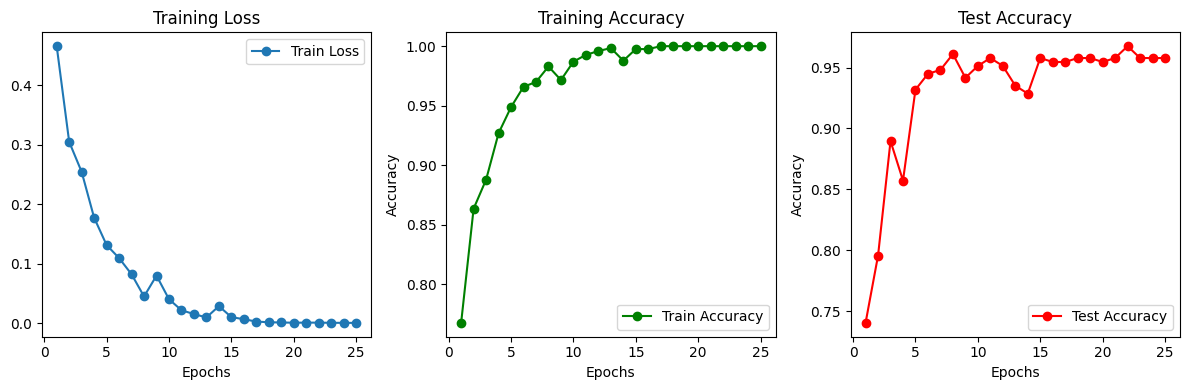

In [15]:
# Plot training loss, training accuracy, and test accuracy
epochs = range(1, EPOCHS + 1)

plt.figure(figsize=(12, 4))

# Plot training loss
plt.subplot(1, 3, 1)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.xlabel('Epochs')
plt.title('Training Loss')
plt.legend()

# Plot training accuracy
plt.subplot(1, 3, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy', marker='o', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

# Plot test accuracy
plt.subplot(1, 3, 3)
plt.plot(epochs, test_accuracies, label='Test Accuracy', marker='o', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

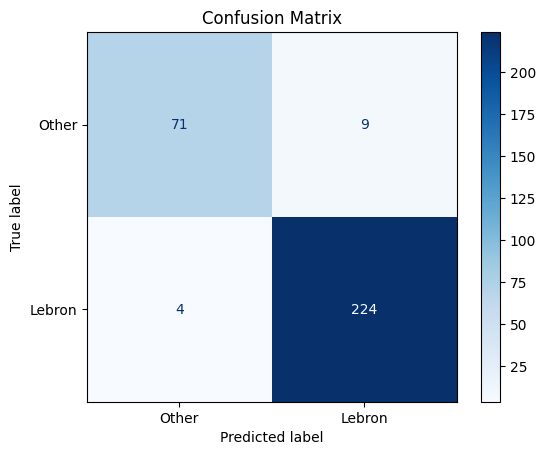

In [16]:
# Collect true labels and predictions
true_labels = []
predicted_labels = []

model.eval()
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.float().unsqueeze(1).to(device)
        logits = model(imgs)
        preds = (torch.sigmoid(logits) > 0.5).float()
        
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

# Flatten the lists
true_labels = [int(label[0]) for label in true_labels]
predicted_labels = [int(pred[0]) for pred in predicted_labels]

# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Other", "Lebron"])

disp.plot(cmap="Blues", ax=plt.gca())
plt.grid(False)  # Turn off the grid
plt.title("Confusion Matrix")
plt.show()

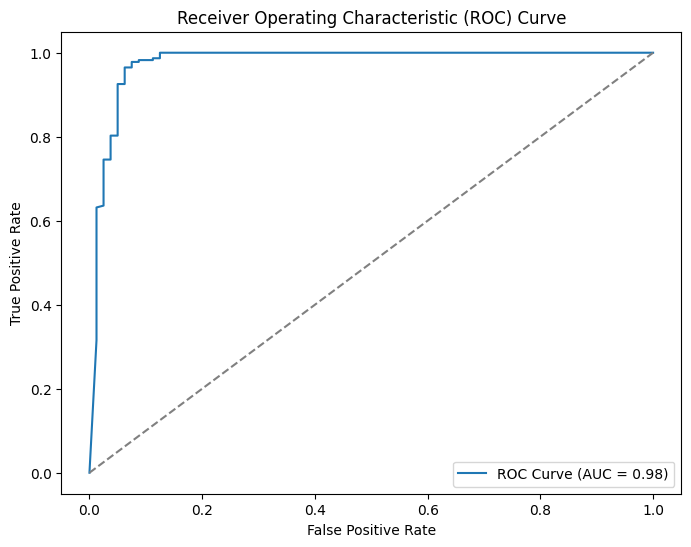

In [17]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(true_labels, predicted_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.show()

False Negatives (Lebron classified as not Lebron): 9


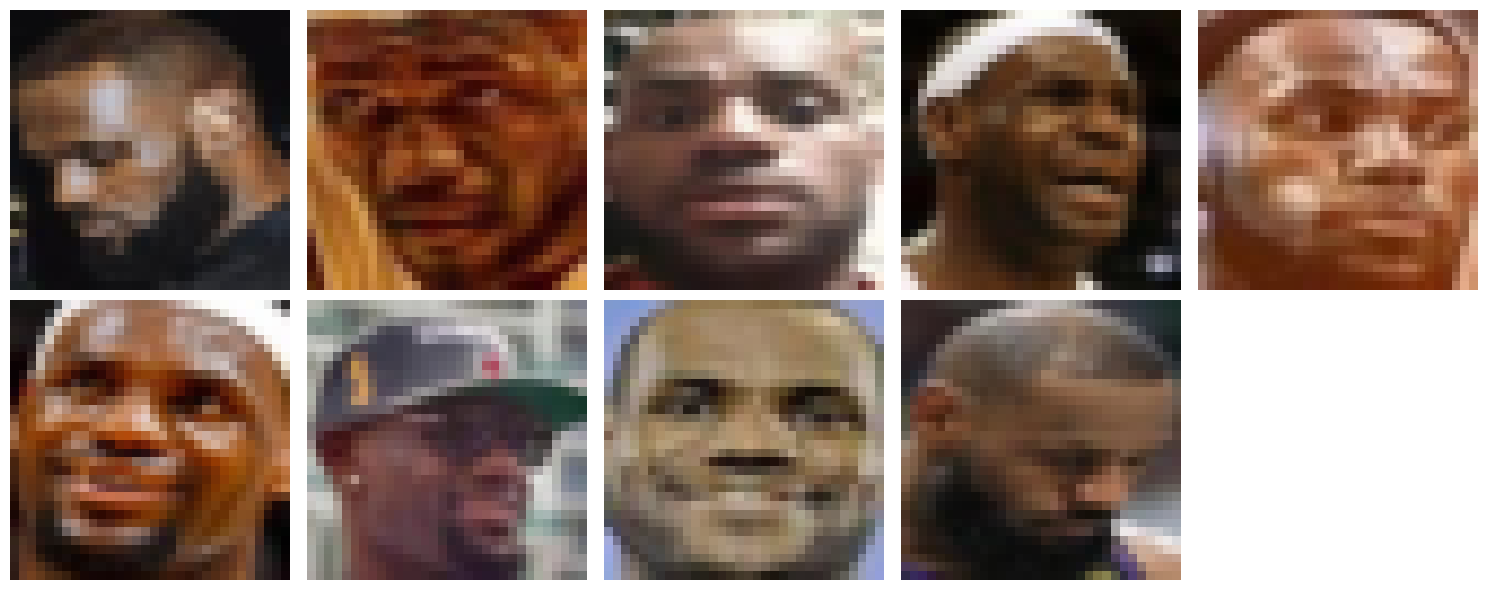

False Positives (NOT Lebron classified as Lebron): 4


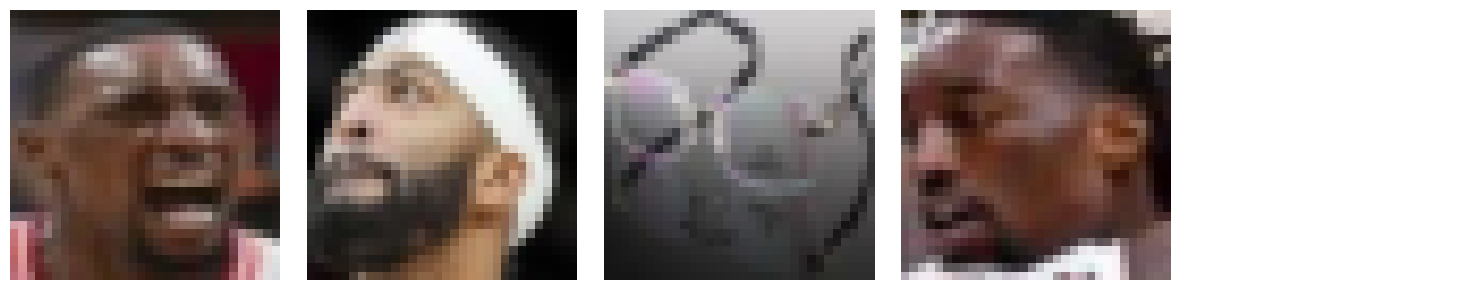

In [18]:
# Collect true labels, predictions, and misclassified images
true_labels = []
predicted_labels = []
false_positive_images = []  # NOT Lebron classified as Lebron
false_negative_images = []  # Lebron classified as NOT Lebron
false_positive_filenames = []
false_negative_filenames = []

model.eval()
with torch.no_grad():
    for batch_idx, (imgs, labels) in enumerate(test_loader):
        imgs, labels = imgs.to(device), labels.float().unsqueeze(1).to(device)
        logits = model(imgs)
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float()
        
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())
        
        # Identify misclassified images
        for img, label, pred, idx in zip(imgs, labels, preds, range(len(labels))):
            dataset_idx = test_set.indices[batch_idx * test_loader.batch_size + idx]  # Get the original dataset index
            filename = full_ds.samples[dataset_idx][0]  # Retrieve the filename from the dataset
            if label.item() == 0 and pred.item() == 1:  # False Positive
                false_positive_images.append(img.cpu())
                false_positive_filenames.append(filename)
            elif label.item() == 1 and pred.item() == 0:  # False Negative
                false_negative_images.append(img.cpu())
                false_negative_filenames.append(filename)

# Display False Positives (NOT Lebron classified as Lebron)
if false_positive_images:
    num_images = len(false_positive_images)
    print(f"False Negatives (Lebron classified as not Lebron): {num_images}")
    
    # Calculate grid size
    cols = 5  # Number of images per row
    rows = math.ceil(num_images / cols)
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
    axes = axes.flatten()  # Flatten the axes array for easy iteration
    
    for i, (img, filename) in enumerate(zip(false_positive_images, false_positive_filenames)):
        img = img.permute(1, 2, 0).numpy() * 0.5 + 0.5  # Unnormalize the image
        axes[i].imshow(img)
        axes[i].axis('off')
        # axes[i].set_title(f"False Negatives\nIndex: {filename}")
    
    # Hide unused axes
    for i in range(num_images, len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("No False Positives found.")

# Display False Negatives (Lebron classified as NOT Lebron)
if false_negative_images:
    num_images = len(false_negative_images)
    print(f"False Positives (NOT Lebron classified as Lebron): {num_images}")
    
    # Calculate grid size
    cols = 5  # Number of images per row
    rows = math.ceil(num_images / cols)
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
    axes = axes.flatten()  # Flatten the axes array for easy iteration
    
    for i, (img, filename) in enumerate(zip(false_negative_images, false_negative_filenames)):
        img = img.permute(1, 2, 0).numpy() * 0.5 + 0.5  # Unnormalize the image
        axes[i].imshow(img)
        axes[i].axis('off')
        # axes[i].set_title(f"False Positive\nIndex: {filename}")
    
    # Hide unused axes
    for i in range(num_images, len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("No False Negatives found.")

# Predict

In [ ]:
from PIL import Image
import torch

# Reverse lookup so 0/1 → folder names (only if you want the class string)
idx_to_class = {v: k for k, v in train_set.dataset.class_to_idx.items()}
# └─ If you used the train/val sub-folder layout, swap `full_ds.dataset` for `train_set.dataset`

def predict_image(path: str,
                  model: torch.nn.Module = model,
                  transform=transform,
                  device: str = "cuda" if torch.cuda.is_available() else "cpu",
                  threshold: float = 0.5):
    """
    Runs a single-image prediction on a *binary* CNN.

    Returns
    -------
    dict
        A dictionary with keys:
        - 'probability' (float): P(class == 1)
        - 'label_idx' (int): 0 or 1
        - 'label_name' (str): Folder name if `idx_to_class` is defined.
        - 'class_probabilities' (dict): Probabilities for both classes.
    """
    # 1. Pre-process
    img = Image.open(path).convert("RGB")
    img.resize((128,128), Image.LANCZOS)  # Resize to match training size
    tensor = transform(img).unsqueeze(0).to(device)  # Add batch dimension

    # 2. Forward pass
    model.eval()
    with torch.no_grad():
        logit = model(tensor)  # shape [1, 1]
        prob = torch.sigmoid(logit).item()

    # 3. Post-process
    label_idx = int(prob > threshold)
    label_name = idx_to_class.get(label_idx, str(label_idx))

    # Class probabilities
    class_probabilities = {
        "Lebron": prob,
        "Other": 1 - prob
    }

    return {
        "probability": prob,
        "label_idx": label_idx,
        "label_name": label_name,
        "class_probabilities": class_probabilities
    }

In [ ]:
result = predict_image("test_photos/lebron1.jpg")
print(f"Predicted class: {result['label_name']} "
      f"(p = {result['probability']:.2%})")
print("Class probabilities:")
for class_name, prob in result['class_probabilities'].items():
    print(f"  {class_name}: {prob:.2%}")

# if result['label_name'] == "lebron":
#     print(f"Lebron is detected, probability: {result['label_name']} {result['probability']:.2%}")
# else:
#     print(f"Lebron is not detected, probability: {result['label_name']} {result['probability']:.2%}")